# Mini Project 5

Welcome to the last Mini Project! In this assignment, you will implement autoencoders (AEs) and generative adversarial networks (GANs) based on the relevant concepts learned in the class.

---
**Requirements**: 
- Your code should follow [PEP 8](https://www.python.org/dev/peps/pep-0008/) with necessary comments.

In [1]:
# Set import path to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
# Supress CUDA erros due to Pytorch
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Task 1: Autoencoders vs. Principal Components Analysis
Principal components analysis (PCA) is a common used method for dimensionality reduction. It's an unsupervised technique that reduces the dimensionality of the data by **orthogonally transforming** the data into a set of principal components. The first principal component explains the most amount of the variation in the data in a single component, the second component explains the second most amount of the variation, etc. By choosing the top principal components that explain say 80-90% of the variation, the other components can be dropped since they do not significantly benefit the model.

Autoencoder is another unsupervised technique can be used for dimensionality reduction in which we leverage neural networks for the task of representation learning. Specifically, a **bottleneck** will be imposed in the network which forces a compressed knowledge representation of the original input.

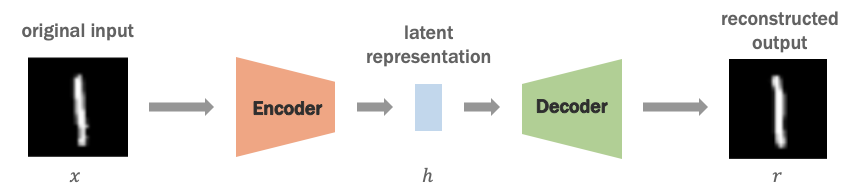


**Tasks**

In this task, you will build two models for dimensionality reduction based on PCA and Autoencoder, respectively. You will use the developed models on the handwritten digits and compare the performance. **The reduced dimension should be two so that the visualization is convenient.**

1. Load [MNIST](https://www.datascienceweekly.org/tutorials/pytorch-mnist-load-mnist-dataset-from-pytorch-torchvision) dataset and preprocess the dataset.
2. Design a PCA model for dimensionality reduction. Please check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for more information.
3. Implement an Autoencoder based on Pytorch.
4. Compare the reconstruction losses (MSE) of PCA and Autoencoder on the test data.
5. Visualize the reduced results of PCA and Autoencoder.
6. Analyse the pros and cons of each model.

### Task 1.1: Load [MNIST](https://www.datascienceweekly.org/tutorials/pytorch-mnist-load-mnist-dataset-from-pytorch-torchvision) dataset and preprocess the dataset.

In [3]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
# Load data
def LoadMNIST(data_dir, verbose=True):
    """
        Load train, valid and test data from Pytorch and save it to the given
        directory. 
        
        Parameters
        ----------
        data_dir: str
            Absolute path of directory to download data.

        Return
        ----------
        train_data: ndarray
            Training dataset.
        valid_data: ndarray
            Validation dataset.
        test_data: ndarray
            Testing dataset.
    """

    transform = transforms.ToTensor() # transform images to tensors

    # Download MNIST train data
    mnist_train = datasets.MNIST(root=data_dir, train=True,
                                    download=True, transform=transform)
    
    # Download MNIST test data
    mnist_test = datasets.MNIST(root=data_dir, train=False,
                                  download=True, transform=transform)

    # Split train data into train and valid
    m = len(mnist_train) # Train set size
    train_data, valid_data = random_split(mnist_train, [int(m-m*0.2), int(m*0.2)]) # Train and valid data
    test_data = mnist_test # Test data

    # Print data size
    if verbose:
        print('Training Data Size: {}'.format(len(train_data))) # Verify shape
        print('Validation Data Size: {}'.format(len(valid_data))) # Verify shape
        print('Testing Data Size: {}'.format(len(test_data))) # Verify shape
    
    return mnist_train, mnist_test, train_data, valid_data, test_data

In [4]:
# Data directory
data_dir = "gdrive/My Drive/AuE-8930 Deep Learning/Mini-Project 5/"

# Load data
mnist_train, mnist_test, train_data, valid_data, test_data = LoadMNIST(data_dir)

# Convert train data into Numpy array
train_arr = mnist_train.data.numpy() # Convert to numpy array
train_arr = train_arr.reshape(train_arr.shape[0],
                              train_arr.shape[1]*train_arr.shape[2]) # Reshape
train_arr = train_arr.astype(np.float32)/255.0 # Normalize

test_arr = mnist_test.data.numpy() # Convert to numpy array
test_arr = test_arr.reshape(test_arr.shape[0],
                            test_arr.shape[1]*test_arr.shape[2]) # Reshape
test_arr = test_arr.astype(np.float32)/255.0 # Normalize

# Create train, valid and test data loaders
batch_size = 256 # Batch size
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size) # Train data loader
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=batch_size) # Valid data loader
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True) # Test data loader

Training Data Size: 48000
Validation Data Size: 12000
Testing Data Size: 10000


### Task 1.2: Design a PCA model for dimensionality reduction. Please check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for more information.

In [4]:
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Reconstruction')

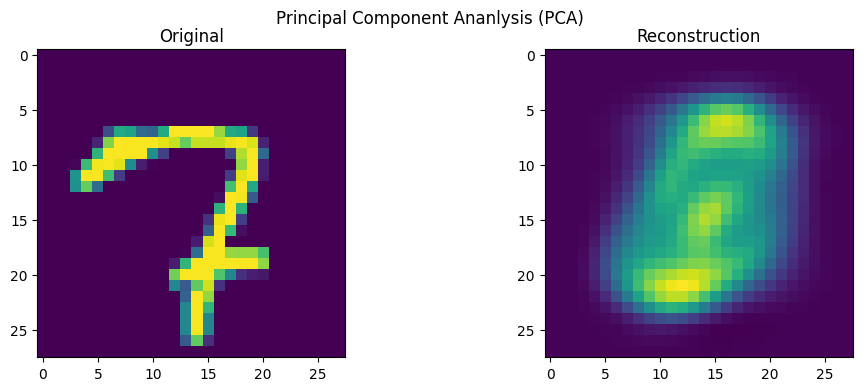

In [6]:
# Define and fit the PCA model
pca = PCA(n_components=3) # PCA with 3 components
components = pca.fit_transform(train_arr) # Get principal components

# Reconstruction error on test set
mu = test_arr.mean(axis=0) # Mean of test data
U,S,V = np.linalg.svd(test_arr - mu, full_matrices=False) # Perform SVD
pca_rep = np.dot(test_arr - mu, V.transpose()) # PCA representation
rec_rep = np.dot(pca_rep[:,:2], V[:2,:]) + mu # Reconstruction
pca_mse = np.sum((test_arr-rec_rep)**2)/rec_rep.shape[0]/rec_rep.shape[1] # MSE

# Reconstruct an image from its principal components
original = test_arr[36].reshape(28, 28) # Original image
reconstruction = pca.inverse_transform(components[36]) # Reconstructed image
reconstruction = reconstruction.reshape(28, 28) # Reshape to same dimensions

# Visualize original and reconstructed images side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # Create side-by-side subplots
fig.suptitle('Principal Component Ananlysis (PCA)') # Common plot title
ax1.imshow(original) # Plot original image
ax1.set_title('Original') # Axis 1 title
ax2.imshow(reconstruction) # Plot reconstructed image
ax2.set_title('Reconstruction') # Axis 2 title

### Task 1.3: Implement an Autoencoder based on Pytorch.

In [5]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Select available device (CPU/GPU)
torch.manual_seed(42) # Fixed seed
!pip install torchviz
from torchviz import make_dot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Define encoder model
class CNNEncoderModel(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # CONV layers
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), # CONV 1
            nn.BatchNorm2d(8), # BATCH_NORM 1
            nn.LeakyReLU(True), # Leaky ReLU
            nn.Conv2d(8, 16, 3, stride=2, padding=1), # CONV 2
            nn.BatchNorm2d(16), # BATCH_NORM 2
            nn.LeakyReLU(True), # Leaky ReLU
            nn.Conv2d(16, 32, 3, stride=2, padding=0), # CONV 3
            nn.LeakyReLU(True) # Leaky ReLU
        )
        # FLATTEN layer
        self.flatten = nn.Flatten(start_dim=1) # FLATTEN
        # FC layers
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128), # FC 1
            nn.ReLU(True), # ReLU
            nn.Linear(128, encoded_space_dim) # FC 2
        )
    def forward(self, x):
        x = self.encoder_cnn(x) # CONV layers
        x = self.flatten(x) # FLATTEN layer
        x = self.encoder_lin(x) # FC layers
        return x

# Define decoder model
class DCNNDecoderModel(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # FC layers
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128), # FC 1
            nn.ReLU(True), # ReLU
            nn.Linear(128, 3 * 3 * 32), # FC 2
            nn.ReLU(True) # ReLU
        )
        # UNFLATTEN layer
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)) # UNFLATTEN
        # DECONV layers
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0), # DECONV 1
            nn.BatchNorm2d(16), # BATCH_NORM 1
            nn.LeakyReLU(True), # Leaky ReLU
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), # DECONV 2
            nn.BatchNorm2d(8), # BATCH_NORM 2
            nn.LeakyReLU(True), # Leaky ReLU
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1) # DECONV 3
        )
    def forward(self, x):
        x = self.decoder_lin(x) # FC layers
        x = self.unflatten(x) # UNFLATTEN layer
        x = self.decoder_conv(x) # DECONV layer
        x = torch.sigmoid(x) # Sigmoid
        return x

In [9]:
# Hyperparameters
latent_dim = 3 # Latent space dimensions
learning_rate = 0.001 # Learning rate
loss_fn = torch.nn.MSELoss() # Loss function
encoder = CNNEncoderModel(encoded_space_dim=latent_dim) # Encoder
decoder = DCNNDecoderModel(encoded_space_dim=latent_dim) # Decoder
encoder.to(device) # Deploy to selected device (CPU/GPU)
decoder.to(device) # Deploy to selected device (CPU/GPU)
params_to_optimize = [{'params': encoder.parameters()},
                      {'params': decoder.parameters()}] # Optimization parameters
optim = torch.optim.Adam(params_to_optimize,
                         lr=learning_rate,
                         weight_decay=1e-05) # Optimizer

In [10]:
# Print and visualize the autoencoder model
print(encoder) # Print encoder model
print(decoder) # Print decoder model
for image_batch, _ in train_loader:
    image_batch = image_batch.to(device)
y = encoder(image_batch) # Encode
x = decoder(y) # Decode

CNNEncoderModel(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)
DCNNDecoderModel(
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inpla

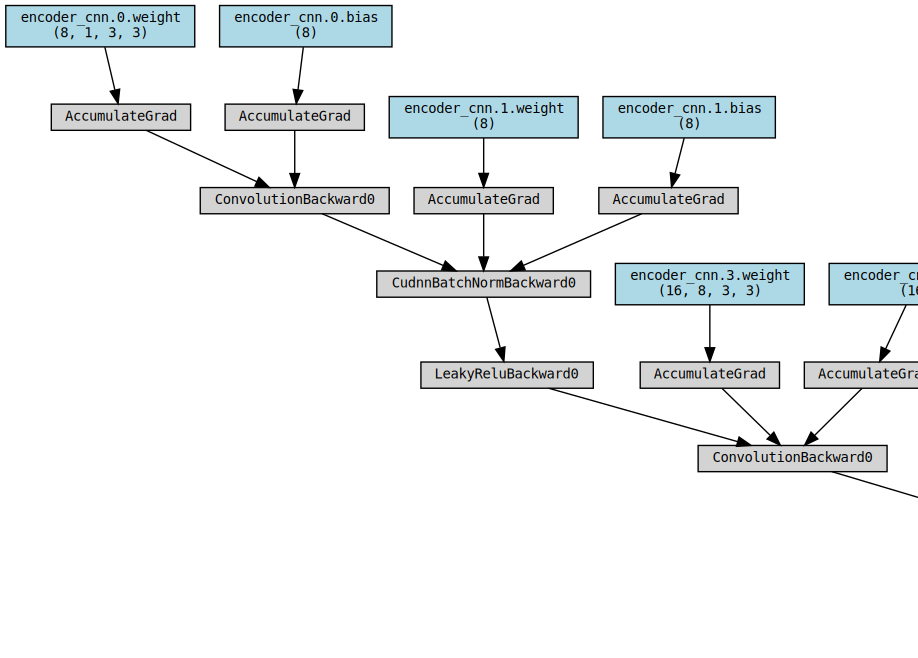

In [11]:
# Visualize encoder
make_dot(y, params=dict(encoder.named_parameters()), show_attrs=False, show_saved=False) # Generate visualization of PyTorch execution graphs and traces

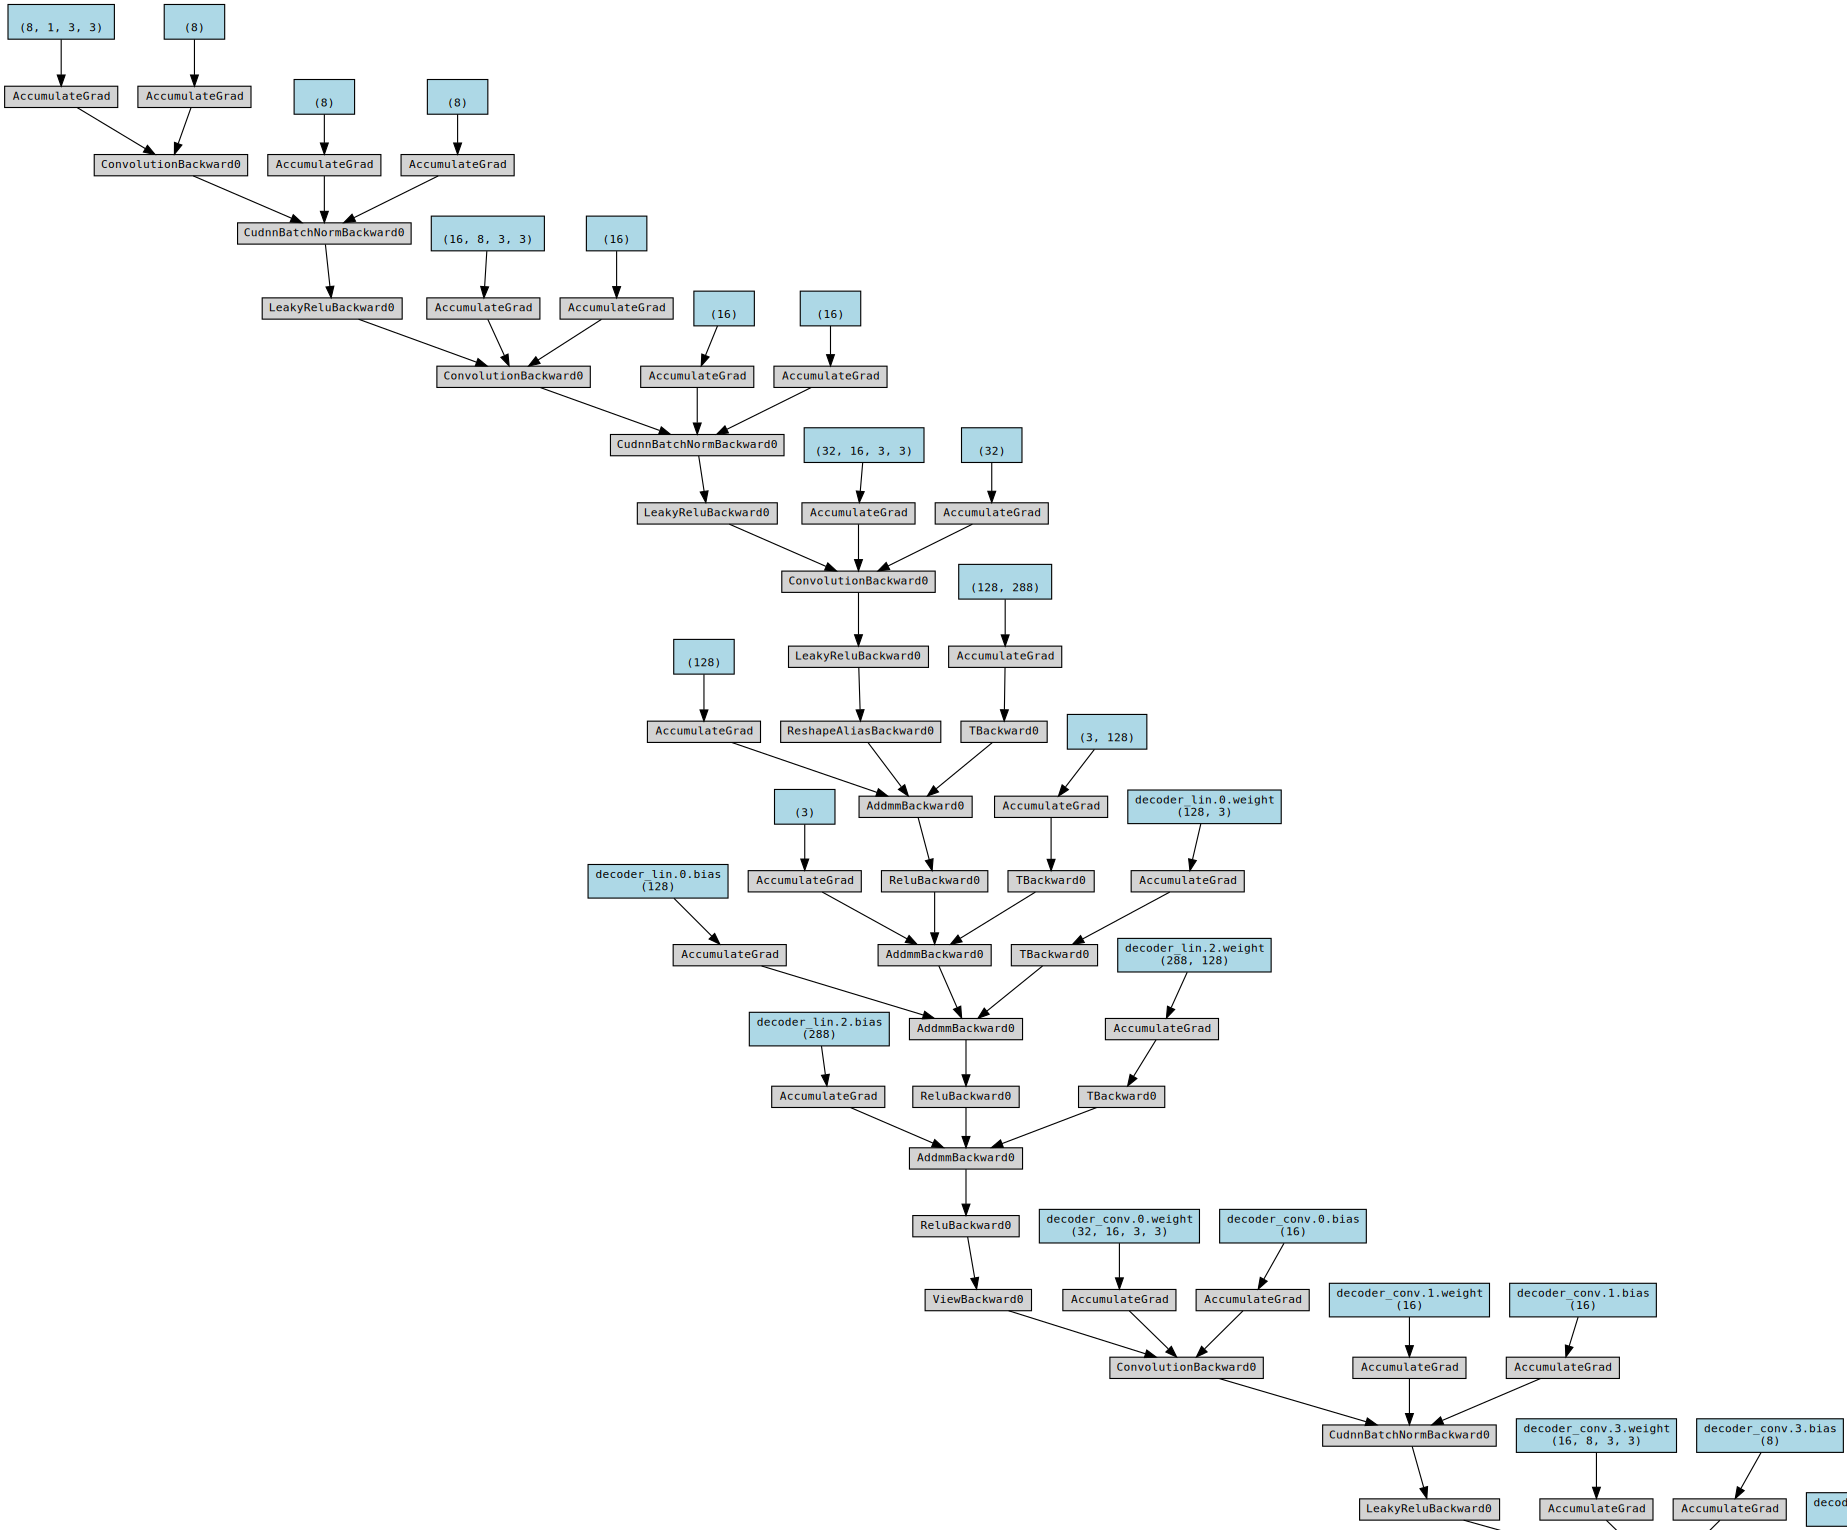

In [12]:
# Visualize decoder
make_dot(x, params=dict(decoder.named_parameters()), show_attrs=False, show_saved=False) # Generate visualization of PyTorch execution graphs and traces

In [13]:
epochs = 30 # Number of epochs
train_loss_hist = [] # Empty list to store training loss history
val_loss_hist = [] # Empty list to store validation loss history

losses = {'train_loss':[],'valid_loss':[]} # Dictionary for storing history of losses

for epoch in range(epochs):
    
    # Training
    encoder.train() # Set encoder in training mode
    decoder.train() # Set decoder in training mode
    train_loss = [] # Train loss history
    for image_batch, _ in train_loader:
        image_batch = image_batch.to(device) # Deploy to selected device (CPU/GPU)
        # Forward propagation
        encoded_data = encoder(image_batch) # Encode data
        decoded_data = decoder(encoded_data) # Decode data
        loss = loss_fn(decoded_data, image_batch) # Compute training loss
        # Backward propagation
        optim.zero_grad() # Set the gradients of all optimized tensors to zero
        loss.backward() # Compute gradients w.r.t. loss
        # Update parameters
        optim.step() # Update parameters based on gradients and update law for given optimizer
        # Compute metrics (loss)
        train_loss.append(loss.detach().cpu().numpy()) # Append train loss
    train_loss = np.mean(train_loss) # Mean train loss value

    # Validation
    encoder.eval() # Set encoder in evaluation mode
    decoder.eval() # Set decoder in evaluation mode
    with torch.no_grad():
        originals = [] # Original inputs for each batch
        reconstructions = [] # Reconstructed outputs for each batch        
        for image_batch, _ in test_loader:
            image_batch = image_batch.to(device) # Deploy to selected device (CPU/GPU)
            encoded_data = encoder(image_batch) # Encode data
            decoded_data = decoder(encoded_data) # Decode data
            # Store history of inputs and outputs
            originals.append(image_batch.cpu()) # Original images
            reconstructions.append(decoded_data.cpu()) # Reconstructions
        # Concatenate into a single tensor
        originals = torch.cat(originals) # Original images
        reconstructions = torch.cat(reconstructions) # Reconstructions
        # Compute metrics (loss)
        test_loss = loss_fn(reconstructions, originals) # Compute valid loss
    valid_loss = test_loss.data # Extract valid loss value

    # Store history of losses
    train_loss_hist.append(train_loss) # Store history of train loss
    val_loss_hist.append(valid_loss) # Store history of valid loss

    # Verbose
    print(f"Epoch: {epoch+1} \t| \tTrain Loss: {train_loss} \t| \tValid Loss: {valid_loss}") # Print train and valid loss for each epoch

Epoch: 1 	| 	Train Loss: 0.11074122041463852 	| 	Valid Loss: 0.06684311479330063
Epoch: 2 	| 	Train Loss: 0.05363665148615837 	| 	Valid Loss: 0.04453161731362343
Epoch: 3 	| 	Train Loss: 0.04201873391866684 	| 	Valid Loss: 0.040130555629730225
Epoch: 4 	| 	Train Loss: 0.03893960267305374 	| 	Valid Loss: 0.03829485550522804
Epoch: 5 	| 	Train Loss: 0.03753700479865074 	| 	Valid Loss: 0.037346843630075455
Epoch: 6 	| 	Train Loss: 0.03670670464634895 	| 	Valid Loss: 0.0368444100022316
Epoch: 7 	| 	Train Loss: 0.03610391914844513 	| 	Valid Loss: 0.03633124381303787
Epoch: 8 	| 	Train Loss: 0.03569634258747101 	| 	Valid Loss: 0.0359761007130146
Epoch: 9 	| 	Train Loss: 0.03535141423344612 	| 	Valid Loss: 0.03550134599208832
Epoch: 10 	| 	Train Loss: 0.03509324789047241 	| 	Valid Loss: 0.0352097749710083
Epoch: 11 	| 	Train Loss: 0.034853558987379074 	| 	Valid Loss: 0.03502319008111954
Epoch: 12 	| 	Train Loss: 0.034642428159713745 	| 	Valid Loss: 0.03473977372050285
Epoch: 13 	| 	Train Loss

<function matplotlib.pyplot.show(close=None, block=None)>

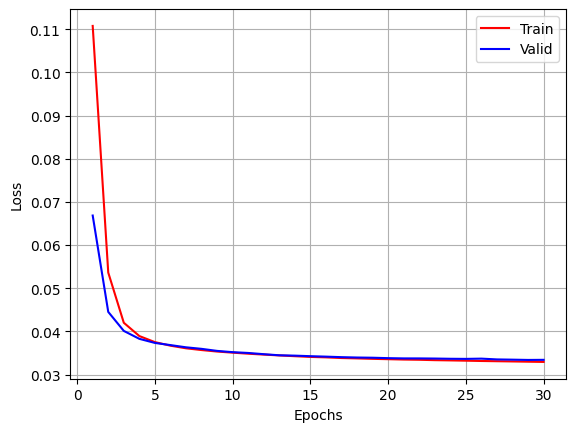

In [14]:
# Plot loss curves
plt.plot(np.linspace(1, epochs, epochs), train_loss_hist, label='Train', color='red') # Plot train loss
plt.plot(np.linspace(1, epochs, epochs), val_loss_hist, label='Valid', color='blue') # Plot test loss
plt.legend(loc='upper right') # Show legend
plt.xlabel('Epochs') # Show label for X-axis
plt.ylabel('Loss') # Show label for Y-axis
plt.grid(True) # Show grid
plt.show # Show plot

Text(0.5, 1.0, 'Reconstruction')

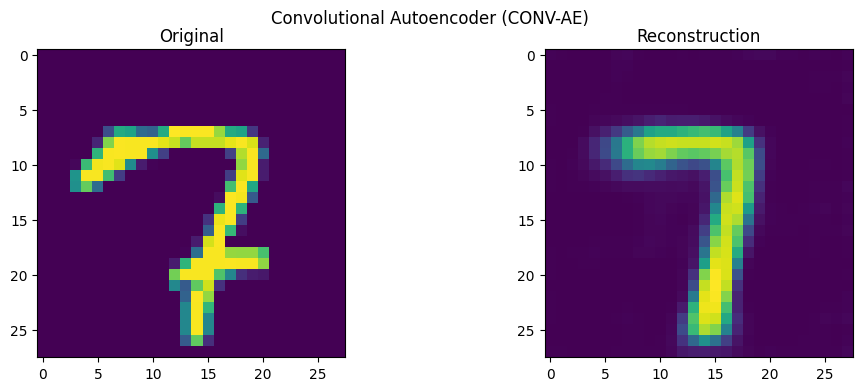

In [15]:
# Reconstruct an image from its latent representation
org_img = mnist_test[36][0].unsqueeze(0).to(device) # Original image
encoder.eval() # Set encoder in evaluation mode
decoder.eval() # Set encoder in evaluation mode
with torch.no_grad():
    rec_img  = decoder(encoder(org_img)) # Reconstructed image
original = org_img.cpu().squeeze() # Original image
reconstruction = rec_img.cpu().squeeze() # Reconstructed image

# Visualize original and reconstructed images side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # Create side-by-side subplots
fig.suptitle('Convolutional Autoencoder (CONV-AE)') # Common plot title
ax1.imshow(original) # Plot original image
ax1.set_title('Original') # Axis 1 title
ax2.imshow(reconstruction) # Plot reconstructed image
ax2.set_title('Reconstruction') # Axis 2 title

### Task 1.4: Compare the reconstruction losses (MSE) of PCA and Autoencoder on the test data.

In [16]:
print('PCA Model MSE:\t\t', round(pca_mse, 4))
print('CONV-AE Model MSE:\t', torch.round(val_loss_hist[-1], decimals=4).numpy())

PCA Model MSE:		 0.0555
CONV-AE Model MSE:	 0.0334


**Inference:** The reconstruction loss (MSE) of Autoencoder is less than PCA.

**Justification:** PCA is a linear dimensionality reduction technique, whereas Autoencoders are non-linear in nature. Since the problem of image compression is not exactly linear and given data is good enough, Autoencoder performs better in this case.

### Task 1.5: Visualize the reduced results of PCA and Autoencoder.

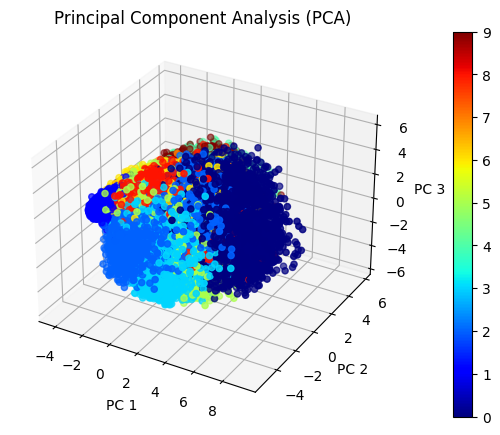

In [17]:
# Visualize latent space representation of PCA model
fig = plt.figure(figsize = (15,5)) # Set figure size
ax = fig.add_subplot(projection='3d') # Create 3D plot
ax.set_title('Principal Component Analysis (PCA)') # Set axis title
sc = ax.scatter(components[:, 0], # Plot principal component 1
                components[:, 1], # Plot principal component 2
                components[:, 2], # Plot principal component 3
                c=np.asarray(mnist_train.targets), # Colormap
                cmap=matplotlib.colormaps['jet'])
ax.set_xlabel('PC 1') # X-axis label
ax.set_ylabel('PC 2') # Y-axis label
ax.set_zlabel('PC 3') # Z-axis label
plt.colorbar(sc) # Colorbar
plt.show() # Show plot

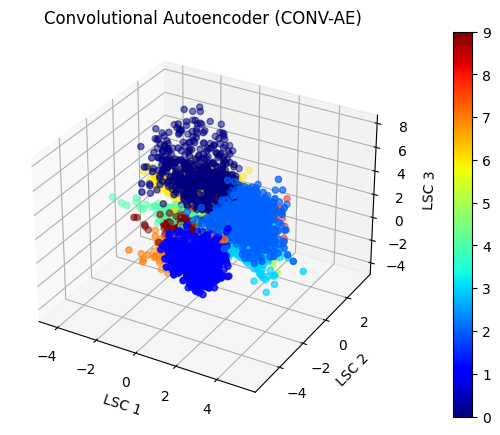

In [18]:
codes = []
for sample in mnist_test:
    image = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    encoder.eval() # Set encoder in evaluation mode
    with torch.no_grad():
        encoded  = encoder(image) # Encode image
    encoded = encoded.flatten().cpu().numpy() # Flatten
    code = {f"dim{i+1}": code for i, code in enumerate(encoded)} # Store latent space co-ordinates
    code['label'] = label # Store labels
    codes.append(code) # Store latent space co-ordinates and corresponding labels

# Visualize latent space representation of CONV-AE model
fig = plt.figure(figsize = (15,5)) # Set figure size
ax = fig.add_subplot(projection='3d') # Create 3D plot
ax.set_title('Convolutional Autoencoder (CONV-AE)') # Set axis title
sc = ax.scatter([sample['dim1'] for sample in codes], # Plot latent space coordinate 1
                [sample['dim2'] for sample in codes], # Plot latent space coordinate 2
                [sample['dim3'] for sample in codes], # Plot latent space coordinate 3
                c=np.asarray(mnist_test.targets), # Colormap
                cmap=matplotlib.colormaps['jet'])
ax.set_xlabel('LSC 1') # X-axis label
ax.set_ylabel('LSC 2') # Y-axis label
ax.set_zlabel('LSC 3') # Z-axis label
plt.colorbar(sc) # Colorbar
plt.show() # Show plot

### Task 1.6: Analyse the pros and cons of each model.

**PCA Pros:**
- Explainable and interpretable first principles approach.
- Faster for linear compression problems.
- No overfitting/underfitting issues.
- Implementing PCA is easier (especially with readily available libraries).

**PCA Cons:**
- Cannot be applied directly to non-linear compression problems.
- PCA is symmetrical by definition.
- PCA may not generalize to complex applications.

**AE Pros:**
- Can be applied directly to both linear as well as non-linear compression problems.
- Can generalize to complex applications based on given data quality and quantity.
- Encoder and decoder architectures may not be symmetrical leading to interesting applications like image transformers, photo filters, upscaling, translation for NLP, etc.

**AE Cons:**
- Not explainable and interpretable.
- Generally requires significantly more time to traing (as compared to PCA)
- May overfit or underfit to the data.
- Implementing autoencoders is difficult (even with readily available libraries) and selection of model architecture and tuning hyperparameters makes it more challenging.

## Task 2: Generative Adversarial Networks
A generative adversarial network (GAN) is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. Two neural networks contest with each other in a game (in the form of a zero-sum game, where one agent's gain is another agent's loss). In this task, you need to create a GAN to generate specific class of figures for given condition (class). For example, give a label "3" (which represents Dress), you will use your network to generate a figure of Dress.

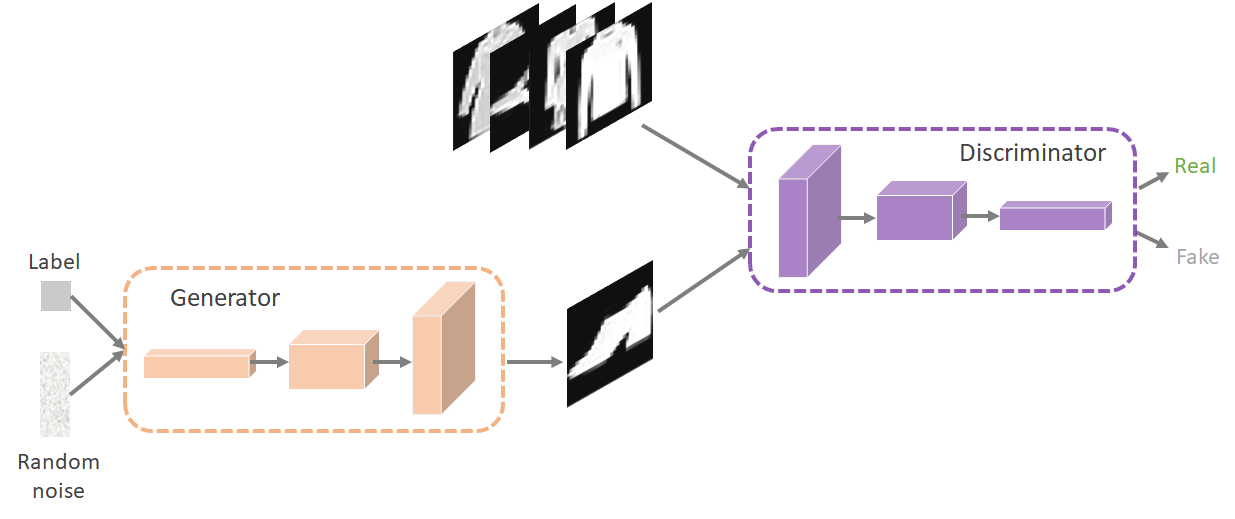



**Dataset**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

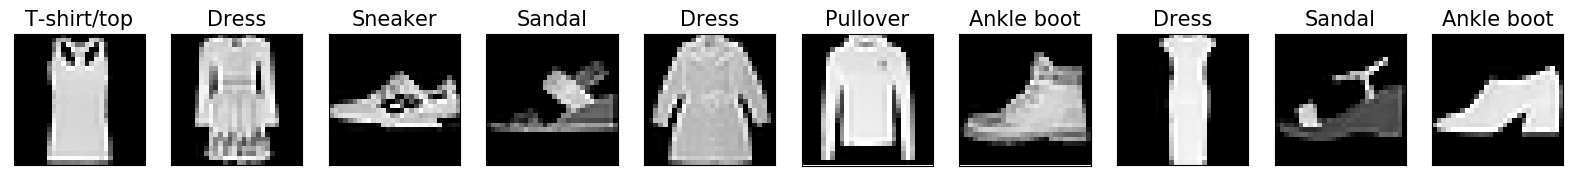

**Tasks**

1. Download the Fashion-MNIST dataset from Canvas and look into the data. Or you can directly load the Fashion-MNIST dataset using [Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
    - The Fashion-MNIST dataset has 60000 training data. Each image is a 28x28 grayscale image, associated with a label from 10 classes. 
2. Create the custom dataset for your project.
3. Build a GAN model based on Pytorch and plot out the model.
4. Train your model and visualize the training history including the loss of Generator and Discriminator.
5. Plot the intermidiate results through the training procedure, e.g. after each 20 epochs in training plot a grid of generated results. (check this [resource](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) to figure out how to save the model and generate the intermediate results during the training)
6. Display final generated results for each of ten classes and discuss your results.

### Task 2.1: Download the Fashion-MNIST dataset.

I downloaded the dataset from CANVAS and uploaded it to Google Drive to integrate it with Google Colab.

### Task 2.2: Create the custom dataset for your project.

In [6]:
import pandas as pd
from PIL import Image

In [7]:
# Data directory
data_dir = "gdrive/My Drive/AuE-8930 Deep Learning/Mini-Project 5/"

In [8]:
class create_data(Dataset):
    def __init__(self, transform=None):
        self.transform = transform # Transform
        fashion_df = pd.read_csv(data_dir+"fashion-mnist_train.csv") # Read data
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28) # Extract features
        self.labels = fashion_df.label.values # Extract labels
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx]) # Get feature corresponding to `idx`
        label = self.labels[idx] # Get label corresponding to `idx`
        if self.transform:
            img = self.transform(img) # Apply transform
        return img, label
    def __len__(self):
        return len(self.images) # Get dataset size

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
                                ]) # Transform
dataset = create_data(transform=transform) # Apply transform
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True) # Data loader

### Task 2.3: Build a GAN model based on Pytorch and plot out the model.

In [9]:
from torch.autograd import Variable

In [10]:
# Define generator model
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(10, 10) # Embedding of labels
        self.model = nn.Sequential(
            nn.Linear(110, 256), # FC 1
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU
            nn.Dropout(0.25), # DROP 1
            nn.Linear(256, 512), # FC 2
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU
            nn.Dropout(0.25), # DROP 2
            nn.Linear(512, 1024), # FC 3
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU
            nn.Dropout(0.25), # DROP 3
            nn.Linear(1024, 784), # FC 4
            nn.Tanh() # TanH
        )
    def forward(self, z, labels):
        z = z.view(z.size(0), 100) # Noise
        c = self.label_embedding(labels) # Embedding of labels
        x = torch.cat([z, c], 1) # Input to generator
        y = self.model(x) # Output of generator
        return y.view(x.size(0), 28, 28)

# Define discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(10, 10) # Embedding of labels
        self.model = nn.Sequential(
            nn.Linear(794, 1024), # FC 1
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU
            nn.Dropout(0.25), # DROP 1
            nn.Linear(1024, 512), # FC 2
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU
            nn.Dropout(0.25), # DROP 2
            nn.Linear(512, 256), # FC 3
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU
            nn.Dropout(0.25), # DROP 3
            nn.Linear(256, 1), # FC 4
            nn.Sigmoid() # Sigmoid
        )
    def forward(self, x, labels):
        x = x.view(x.size(0), 784) # Real image
        c = self.label_embedding(labels) # Embedding of labels
        z = torch.cat([x, c], 1) # Input to discriminator
        y = self.model(z) # Output of discriminator
        return y.squeeze()

In [11]:
# Hyperparameters
generator = Generator().to(device) # Deploy to selected device (CPU/GPU)
discriminator = Discriminator().to(device) # Deploy to selected device (CPU/GPU)
criterion = nn.BCELoss() # Loss function
genr_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4) # Optimizer and learning rate for generator
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4) # Optimizer and learning rate for discriminator

In [12]:
# Print and visualize the GAN model
print(generator) # Print generator model
print(discriminator) # Print discriminator model
for i, (images, labels) in enumerate(data_loader):
    real_images = Variable(images).to(device) # Deploy to selected device (CPU/GPU)
    labels = Variable(labels).to(device) # Deploy to selected device (CPU/GPU)
    batch_size = real_images.size(0) # Compute batch size based on data
    z = Variable(torch.randn(batch_size, 100)).to(device) # Deploy to selected device (CPU/GPU)
fake_images = generator(z, labels) # Generator outputs
validations = discriminator(fake_images, labels) # Discriminator outputs

Generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)
Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.25, i

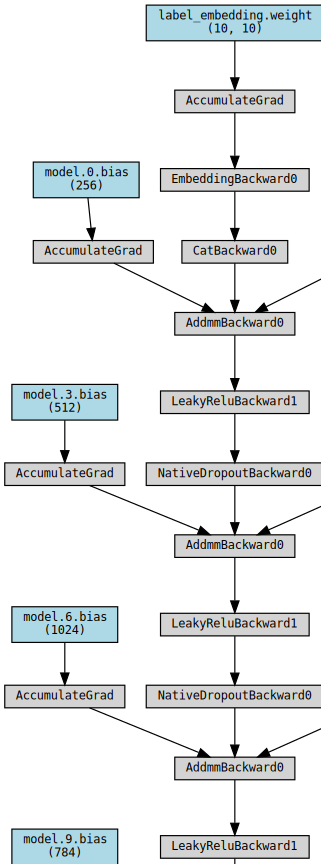

In [13]:
make_dot(fake_images, params=dict(generator.named_parameters()), show_attrs=False, show_saved=False) # Generate visualization of PyTorch execution graphs and traces

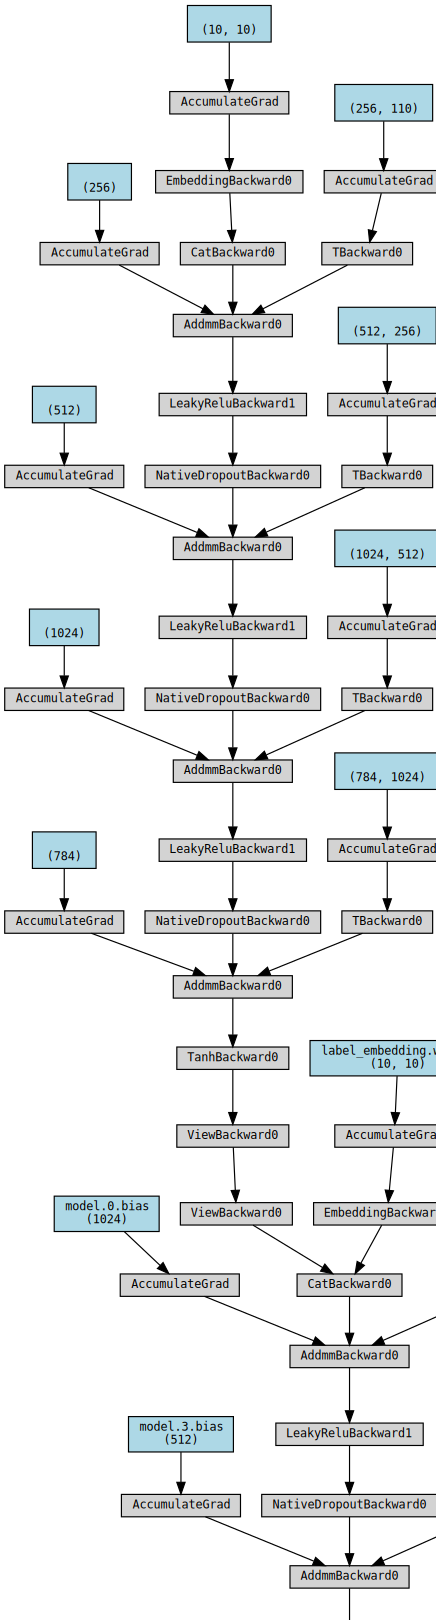

In [14]:
make_dot(validations, params=dict(discriminator.named_parameters()), show_attrs=False, show_saved=False) # Generate visualization of PyTorch execution graphs and traces

### Task 2.4 and 2.5: Train your model and visualize the training history including the loss of Generator and Discriminator. Plot the intermidiate results through the training procedure.

In [15]:
from torchvision.utils import make_grid

Epoch: 1 	| 	Generator Loss: 3.7437617778778076 	| 	Discriminator Loss: 0.15756531059741974


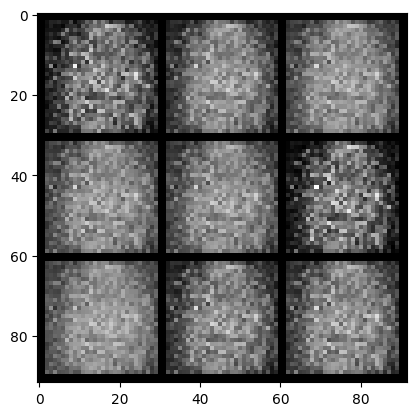

Epoch: 2 	| 	Generator Loss: 3.287034034729004 	| 	Discriminator Loss: 0.4816665053367615
Epoch: 3 	| 	Generator Loss: 2.497628688812256 	| 	Discriminator Loss: 0.3969650864601135
Epoch: 4 	| 	Generator Loss: 3.6240429878234863 	| 	Discriminator Loss: 0.581270694732666
Epoch: 5 	| 	Generator Loss: 3.613001585006714 	| 	Discriminator Loss: 0.7089048624038696


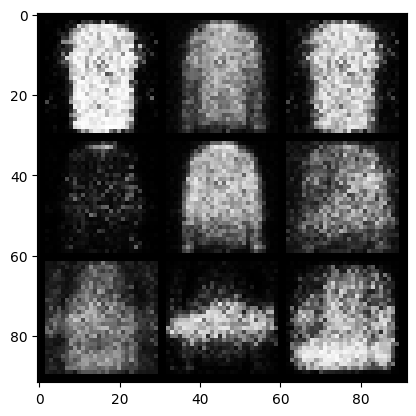

Epoch: 6 	| 	Generator Loss: 2.502715826034546 	| 	Discriminator Loss: 0.665205180644989
Epoch: 7 	| 	Generator Loss: 2.4269564151763916 	| 	Discriminator Loss: 0.5442783236503601
Epoch: 8 	| 	Generator Loss: 1.703399896621704 	| 	Discriminator Loss: 0.5353782176971436
Epoch: 9 	| 	Generator Loss: 2.3951549530029297 	| 	Discriminator Loss: 0.7824598550796509
Epoch: 10 	| 	Generator Loss: 1.934251308441162 	| 	Discriminator Loss: 0.9301649332046509


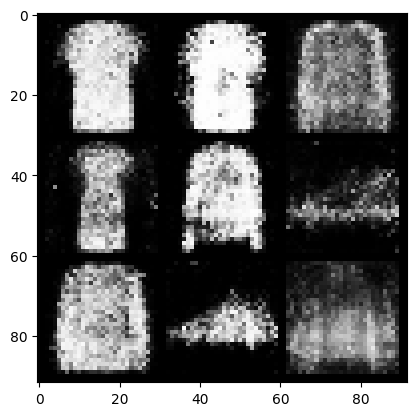

Epoch: 11 	| 	Generator Loss: 1.6375458240509033 	| 	Discriminator Loss: 0.8281658291816711
Epoch: 12 	| 	Generator Loss: 1.5177191495895386 	| 	Discriminator Loss: 0.5609486103057861
Epoch: 13 	| 	Generator Loss: 1.8688273429870605 	| 	Discriminator Loss: 1.091020107269287
Epoch: 14 	| 	Generator Loss: 1.6205580234527588 	| 	Discriminator Loss: 0.978736162185669
Epoch: 15 	| 	Generator Loss: 1.6267914772033691 	| 	Discriminator Loss: 0.5899138450622559


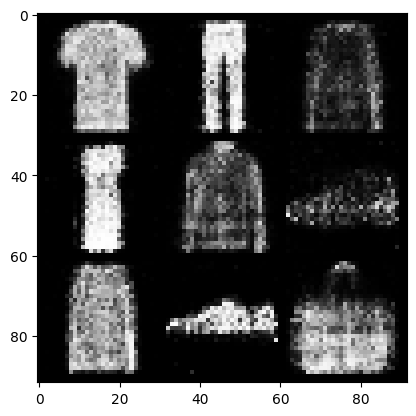

Epoch: 16 	| 	Generator Loss: 2.1163949966430664 	| 	Discriminator Loss: 0.7946510314941406
Epoch: 17 	| 	Generator Loss: 1.507869839668274 	| 	Discriminator Loss: 0.9588726758956909
Epoch: 18 	| 	Generator Loss: 1.1257109642028809 	| 	Discriminator Loss: 0.9786995053291321
Epoch: 19 	| 	Generator Loss: 1.7127561569213867 	| 	Discriminator Loss: 0.8648014664649963
Epoch: 20 	| 	Generator Loss: 1.6619035005569458 	| 	Discriminator Loss: 1.0905390977859497


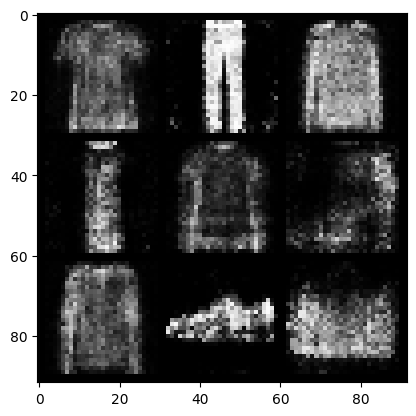

Epoch: 21 	| 	Generator Loss: 1.4027609825134277 	| 	Discriminator Loss: 0.8640305995941162
Epoch: 22 	| 	Generator Loss: 1.4637563228607178 	| 	Discriminator Loss: 0.7390808463096619
Epoch: 23 	| 	Generator Loss: 1.742964506149292 	| 	Discriminator Loss: 0.7696936130523682
Epoch: 24 	| 	Generator Loss: 1.5782853364944458 	| 	Discriminator Loss: 1.207256555557251
Epoch: 25 	| 	Generator Loss: 1.2238589525222778 	| 	Discriminator Loss: 0.9613990783691406


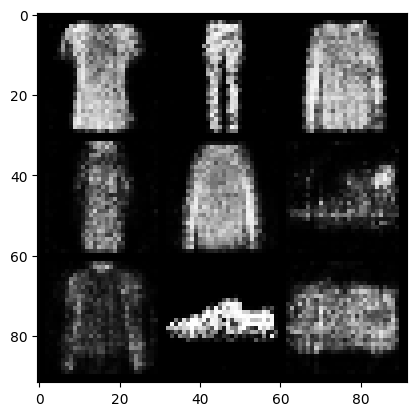

Epoch: 26 	| 	Generator Loss: 1.4079748392105103 	| 	Discriminator Loss: 1.0772645473480225
Epoch: 27 	| 	Generator Loss: 1.3530027866363525 	| 	Discriminator Loss: 0.9880818724632263
Epoch: 28 	| 	Generator Loss: 1.1627229452133179 	| 	Discriminator Loss: 1.0613937377929688
Epoch: 29 	| 	Generator Loss: 1.4388835430145264 	| 	Discriminator Loss: 1.0547051429748535
Epoch: 30 	| 	Generator Loss: 1.1903584003448486 	| 	Discriminator Loss: 1.1365634202957153


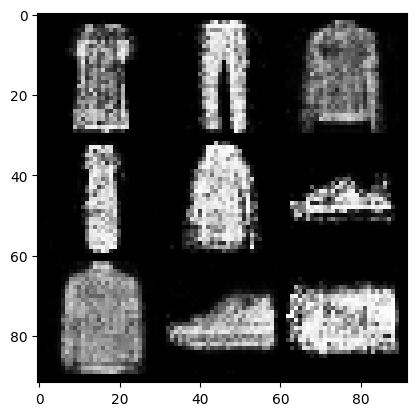

In [16]:
epochs = 30 # Number of epochs
genr_loss_hist = [] # Empty list to store generator loss history
disc_loss_hist = [] # Empty list to store discriminator loss history

for epoch in range(epochs):
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).to(device) # Deploy to selected device (CPU/GPU)
        labels = Variable(labels).to(device) # Deploy to selected device (CPU/GPU)
        batch_size = real_images.size(0) # Compute batch size based on data
        generator.train() # Set generator in training mode

        # Train Discriminator
        disc_optimizer.zero_grad() # Set the gradients of all optimized tensors to zero
        real_validations = discriminator(real_images, labels) # Validation of real images
        real_loss = criterion(real_validations, Variable(torch.ones(batch_size)).to(device)) # Loss on real images
        z = Variable(torch.randn(batch_size, 100)).to(device) # Deploy to selected device (CPU/GPU)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device) # Deploy to selected device (CPU/GPU)
        fake_images = generator(z, fake_labels) # Generator outputs
        fake_validations = discriminator(fake_images, fake_labels) # Validation of fake images
        fake_loss = criterion(fake_validations, Variable(torch.zeros(batch_size)).to(device)) # Loss on fake images
        disc_loss = real_loss + fake_loss # Net loss
        disc_loss.backward() # Back propagation
        disc_optimizer.step() # Parameter update
        disc_loss = disc_loss.data # Discriminator loss value

        # Train Generator
        genr_optimizer.zero_grad() # Set the gradients of all optimized tensors to zero
        z = Variable(torch.randn(batch_size, 100)).to(device) # Deploy to selected device (CPU/GPU)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device) # Deploy to selected device (CPU/GPU)
        fake_images = generator(z, fake_labels) # Generation of fake images (using generator)
        validations = discriminator(fake_images, fake_labels) # Validation of fake images (using discriminator)
        genr_loss = criterion(validations, Variable(torch.ones(batch_size)).to(device)) # Loss
        genr_loss.backward() # Back propagation
        genr_optimizer.step() # Parameter update
        genr_loss = genr_loss.data # Generator loss value

        # Store history of losses
        disc_loss_hist.append(disc_loss.cpu()) # Store history of discriminator loss
        genr_loss_hist.append(genr_loss.cpu()) # Store history of generator loss

    # Verbose
    print(f"Epoch: {epoch+1} \t| \tGenerator Loss: {genr_loss} \t| \tDiscriminator Loss: {disc_loss}") # Print generator and discriminator loss for each epoch

    # Plot the intermidiate results of generator
    if epoch == 0 or (epoch+1) % 5 == 0: # Plot every 5 epochs (including first epoch)
        generator.eval() # Set generator in evaluation mode
        z = Variable(torch.randn(9, 100)).to(device) # Deploy to selected device (CPU/GPU)
        labels = Variable(torch.LongTensor(np.arange(9))).to(device) # Deploy to selected device (CPU/GPU)
        gen_images = generator(z, labels).unsqueeze(1).data.cpu() # Output of generator
        grid = make_grid(gen_images, nrow=3, normalize=True).permute(1,2,0).numpy() # Create grid
        plt.imshow(grid) # Plot grid
        plt.show() # Show plot

<function matplotlib.pyplot.show(close=None, block=None)>

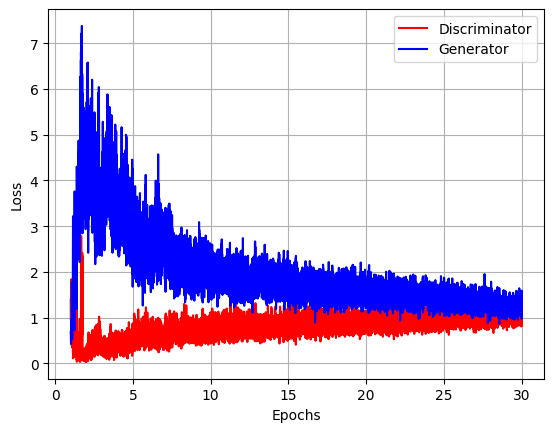

In [17]:
# Plot loss curves
plt.plot(np.linspace(1, epochs, len(disc_loss_hist)), disc_loss_hist, label='Discriminator', color='red') # Plot train loss
plt.plot(np.linspace(1, epochs, len(genr_loss_hist)), genr_loss_hist, label='Generator', color='blue') # Plot test loss
plt.legend(loc='upper right') # Show legend
plt.xlabel('Epochs') # Show label for X-axis
plt.ylabel('Loss') # Show label for Y-axis
plt.grid(True) # Show grid
plt.show # Show plot

### Task 2.6.1: Display final generated results for each of ten classes.

Text(0.5, 0, 'Ankle Boot')

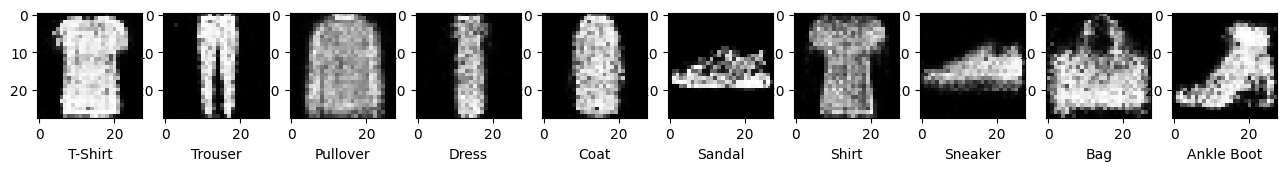

In [34]:
z = Variable(torch.randn(10, 100)).to(device) # Deploy to selected device (CPU/GPU)
labels = Variable(torch.LongTensor(np.arange(10))).to(device) # Deploy to selected device (CPU/GPU)
generator.eval() # Set generator in evaluation mode
gen_images = generator(z, labels).unsqueeze(1).data.cpu() # Generator outputs
fig, ax = plt.subplots(1, 10, figsize=(16, 2)) # Set figure size
ax[0].imshow(gen_images[0].squeeze(), cmap='gray') # Show image
ax[0].set_xlabel('T-Shirt') # Set axis label
ax[1].imshow(gen_images[1].squeeze(), cmap='gray') # Show image
ax[1].set_xlabel('Trouser') # Set axis label
ax[2].imshow(gen_images[2].squeeze(), cmap='gray') # Show image
ax[2].set_xlabel('Pullover') # Set axis label
ax[3].imshow(gen_images[3].squeeze(), cmap='gray') # Show image
ax[3].set_xlabel('Dress') # Set axis label
ax[4].imshow(gen_images[4].squeeze(), cmap='gray') # Show image
ax[4].set_xlabel('Coat') # Set axis label
ax[5].imshow(gen_images[5].squeeze(), cmap='gray') # Show image
ax[5].set_xlabel('Sandal') # Set axis label
ax[6].imshow(gen_images[6].squeeze(), cmap='gray') # Show image
ax[6].set_xlabel('Shirt') # Set axis label
ax[7].imshow(gen_images[7].squeeze(), cmap='gray') # Show image
ax[7].set_xlabel('Sneaker') # Set axis label
ax[8].imshow(gen_images[8].squeeze(), cmap='gray') # Show image
ax[8].set_xlabel('Bag') # Set axis label
ax[9].imshow(gen_images[9].squeeze(), cmap='gray') # Show image
ax[9].set_xlabel('Ankle Boot') # Set axis label

### Task 2.6.2: Discuss your results.

- Initially, generator mostly outputs noise and the discriminator can easily  differentiate the output of generator from the real images. Consequently, the generator learns quickly to start generating outputs, which the discriminator cannot differentiate easily and incurs high loss. The discriminator then gets better at identifying the minute differences between the real and fake images.

- This process continues for predefined number of epochs, which is generally set after observing the "learning performance" (trend of loss curves) of both generator and discriminator models.

- The generator eventually learned to generate images quite similar to the actual dataset. The fact that both generator and discriminator losses were converged towards the end of training indicates that the generator was confident with the generated (fake) images and discriminator could not differentiate between the fake and real images.

- It is to be noted that the loss curves fluctuate frequently due to the adversarial nature of GANs, wherein sometimes the generator wins (is able to fool the discriminator) and other times the discriminator wins (is able to detect the fake output of generator).